**AUTOENCODER IMPLEMENTATION USING CREDITCARD DATASET**

*We will build applications using various versions of
autoencoders, including undercomplete, overcomplete, sparse, denoising,
and variational autoencoders.*

*To start, let’s return to the credit card fraud detection problem. 
For this problem, we have 284,807 credit card transactions, of
which only 492 are fraudulent. Let’s see how this same problem can be solved using an autoencoder, which
is also an unsupervised algorithm but one that uses a neural network.*

**IMPORT RELEVANT DATA**

In [1]:
# main
import numpy as np
import pandas as pd
import os, time, re

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

# Data Prep and Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Algos
import lightgbm as lgb

# TensorFlow and Keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

**READ THE DATASET**

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


**CREATE THE FEATURES AND LABELS**

In [4]:
X = df.copy().drop(['Time', 'Class'], axis=1)
y = df['Class'].copy()

In [5]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [6]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

**SEPERATE THE TRAIN AND TEST DATASET**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101, stratify=y)

In [8]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
268384,-0.413298,0.765959,-0.198850,-0.048364,0.005327,-0.417354,0.498339,0.094569,0.746672,-1.090161,...,-0.290372,0.215807,1.033833,-0.121094,1.149500,-0.007167,0.676796,-0.493060,-0.294532,49.25
192363,2.189822,-0.538914,-2.161428,-0.811728,-0.146739,-1.881075,0.360173,-0.545654,-1.237398,1.121854,...,-0.122698,0.567846,1.644329,-0.164029,0.572202,0.616235,0.253069,-0.101908,-0.098336,20.00
33870,-0.996416,0.794408,0.559732,0.753005,0.982240,1.498194,0.929516,-0.010127,0.026761,0.780818,...,0.264006,-0.197172,0.077761,-0.404199,-1.684088,0.136073,-0.179203,0.119474,0.131550,101.00
252538,-1.024432,0.788858,-1.503405,-1.093315,2.705762,0.579780,1.337205,-0.084136,-0.526318,-0.002315,...,-0.476379,0.571143,1.692937,-0.429515,-0.650836,-0.051398,0.002083,-0.559892,0.381007,1.18
211816,1.907546,-0.718366,0.110821,0.382081,-1.003015,0.228108,-1.185213,0.275804,1.902281,-0.184271,...,-0.189975,0.238841,0.787460,0.217203,0.588819,-0.378426,-0.292095,0.061425,-0.015245,30.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167123,0.010860,-3.269589,-3.245118,1.354180,-0.602921,-0.749390,1.707960,-0.522285,0.425545,-0.885831,...,1.939384,0.393551,-1.241044,-0.700831,0.667167,-0.492101,0.222566,-0.285735,0.150815,1075.03
47862,-0.976667,0.385127,2.023233,-0.133729,0.685390,1.859052,0.155075,0.785934,-0.403700,-0.794432,...,-0.106317,-0.059086,-0.056841,-0.019533,-1.026330,-0.106662,0.326585,0.074670,0.042326,29.95
57567,-0.605181,0.990861,0.825643,0.703275,0.701805,-0.346153,0.865577,-0.188318,-0.592107,0.053389,...,0.240145,0.082198,0.439118,-0.142814,-0.407303,-0.015504,-0.278112,0.298534,0.237226,36.00
102906,-0.709482,1.073567,1.543798,-0.139379,-0.248166,-0.743206,0.512217,0.144107,-0.303357,0.199758,...,0.149754,-0.208417,-0.558001,0.035504,0.480530,-0.233725,0.050521,0.363380,0.168191,1.78


In [9]:
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
139006,-0.880105,0.491262,2.487989,0.378473,-0.429940,0.148149,0.498055,0.194302,-0.027862,-0.916661,...,0.049515,0.325864,0.940881,-0.015409,0.415097,0.022654,-0.401708,0.133099,0.136276,89.00
34626,1.160467,0.047953,0.560250,0.517375,-0.471830,-0.351722,-0.220201,0.154796,0.001032,0.104399,...,-0.221103,-0.182960,-0.605675,0.198064,0.176676,0.035489,0.099441,-0.026025,0.004033,0.89
281000,-0.620566,1.437607,-1.308060,-1.252164,0.976648,-1.145307,1.160519,0.196552,-0.577079,-0.213273,...,-0.056414,0.299732,0.915155,-0.148496,0.798747,-0.265893,0.041193,0.364891,0.261807,1.54
37645,-1.464310,-1.723400,1.650829,-2.643772,-1.170359,-0.012051,0.678344,-0.579602,1.276801,-0.416989,...,-1.293594,-0.809727,-0.310714,0.724238,0.098751,-0.086293,-0.258521,-0.145892,-0.664194,195.28
266307,-0.511213,1.754969,-1.342946,0.856781,1.462879,-0.010130,1.213390,0.312482,-1.285914,-0.731059,...,0.210923,0.107544,0.427863,-0.237630,0.000495,0.191056,-0.393865,0.312431,0.210207,51.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10258,1.136522,0.324319,0.738586,1.492681,-0.358807,-0.526007,-0.104351,-0.100933,1.386261,-0.353821,...,-0.244027,-0.140323,-0.155475,0.049714,0.304320,0.379681,-0.431489,0.005686,0.020052,17.94
249916,1.957061,-0.333049,0.156875,0.472494,-0.901511,-0.476315,-0.713090,-0.072368,1.318083,-0.221638,...,-0.106627,0.098595,0.556753,0.248773,0.080055,-0.334878,-0.417901,0.068647,-0.021790,9.12
140621,-0.455162,0.784149,1.554869,1.549437,0.096225,-0.575996,0.750291,-0.187905,-1.022923,-0.101692,...,0.413847,0.141741,0.340836,-0.145366,0.431878,0.521884,-0.046152,0.016232,0.015263,66.57
21826,-1.364276,-0.404955,1.237717,1.102449,0.337029,-0.523323,1.045120,-0.051326,-1.133407,-0.279890,...,0.820874,0.396504,0.497203,0.448393,0.332648,0.216338,-0.299380,0.013806,0.149579,250.00


In [10]:
y_train

268384    0
192363    0
33870     0
252538    0
211816    0
         ..
167123    0
47862     0
57567     0
102906    0
252213    0
Name: Class, Length: 190820, dtype: int64

In [11]:
y_test

139006    0
34626     0
281000    0
37645     0
266307    0
         ..
10258     0
249916    0
140621    0
21826     0
58911     0
Name: Class, Length: 93987, dtype: int64

**SCALE THE FEATURE DATASET**

In [12]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
X_train.loc[:,X.columns] = scaler.fit_transform(X_train.loc[:,X.columns])

In [14]:
scaled_X_train = X_train.copy()

In [15]:
X_test.loc[:,X.columns] = scaler.transform(X_test.loc[:,X.columns])

In [16]:
scaled_X_test = X_test.copy()

In [17]:
scaled_X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
268384,-0.208868,0.462359,-0.131427,-0.034168,0.001576,-0.311142,0.398411,0.080321,0.675215,-0.999298,...,-0.377487,0.296273,1.425156,-0.191667,1.897004,-0.016422,1.401224,-1.216456,-0.878318,-0.154483
192363,1.115734,-0.323954,-1.426012,-0.572939,-0.106915,-1.402607,0.288197,-0.461446,-1.127146,1.025543,...,-0.160672,0.779788,2.267781,-0.260037,0.943497,1.181969,0.524234,-0.251234,-0.293267,-0.270226
33870,-0.505589,0.479502,0.368961,0.531428,0.698550,1.117241,0.742356,-0.008274,0.021236,0.713365,...,0.339365,-0.270942,0.105556,-0.642489,-2.783152,0.258934,-0.370441,0.295056,0.392248,0.050294
252538,-0.519845,0.476158,-0.991957,-0.771680,1.928188,0.432399,1.067565,-0.070902,-0.481189,-0.003502,...,-0.618008,0.784317,2.334871,-0.682801,-1.076559,-0.101450,0.004767,-1.381373,1.136126,-0.344698
211816,0.972098,-0.432092,0.072844,0.269635,-0.717820,0.170165,-0.944541,0.233685,1.724989,-0.170061,...,-0.247665,0.327910,1.085104,0.347044,0.970943,-0.730107,-0.604095,0.151812,-0.045490,-0.226778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167123,0.006966,-1.969452,-2.140852,0.955729,-0.432375,-0.558734,1.363312,-0.441671,0.383498,-0.812258,...,2.505752,0.540400,-1.714700,-1.114850,1.100348,-0.948629,0.461102,-0.704854,0.449696,3.904571
47862,-0.495540,0.232870,1.334339,-0.094417,0.486764,1.386325,0.124592,0.665364,-0.369801,-0.728593,...,-0.139490,-0.081285,-0.080226,-0.029940,-1.696752,-0.207686,0.676391,0.184495,0.126184,-0.230854
57567,-0.306508,0.597884,0.544366,0.496329,0.498475,-0.258049,0.691352,-0.159063,-0.540953,0.047489,...,0.308510,0.112765,0.604311,-0.226255,-0.674322,-0.032449,-0.575154,0.736909,0.707373,-0.206914
102906,-0.359582,0.647723,1.018086,-0.098405,-0.179277,-0.554123,0.409481,0.122241,-0.278648,0.181472,...,0.191629,-0.286387,-0.771942,0.057703,0.792087,-0.451943,0.105019,0.896926,0.501510,-0.342324


In [18]:
scaled_X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
139006,-0.446404,0.296827,1.640908,0.267088,-0.308963,0.110541,0.398184,0.164717,-0.028383,-0.840478,...,0.062013,0.447434,1.296860,-0.023372,0.684012,0.040904,-0.830961,0.328676,0.406341,0.002810
34626,0.591945,0.029690,0.369303,0.365123,-0.338849,-0.262202,-0.174761,0.131285,-0.002136,0.094182,...,-0.287917,-0.251423,-0.837744,0.316566,0.290220,0.065577,0.206270,-0.063984,0.011996,-0.345845
281000,-0.314337,0.867092,-0.863100,-0.883794,0.694560,-0.853961,0.926625,0.166620,-0.527301,-0.196609,...,-0.074962,0.411541,1.261352,-0.235302,1.317675,-0.513782,0.085713,0.900655,0.780671,-0.343273
37645,-0.743678,-1.037722,1.088687,-1.865972,-0.837211,-0.008917,0.541999,-0.490173,1.156794,-0.383087,...,-1.674726,-1.112270,-0.430629,1.154455,0.161512,-0.168529,-0.534606,-0.359772,-1.980643,0.423364
266307,-0.258692,1.058334,-0.886112,0.604672,1.041460,-0.007484,0.968799,0.264722,-1.171219,-0.670582,...,0.270725,0.147577,0.588777,-0.377241,-0.000774,0.364630,-0.814729,0.771203,0.626803,-0.147123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10258,0.579761,0.196228,0.486940,1.053481,-0.258213,-0.392163,-0.082348,-0.085116,1.256228,-0.325265,...,-0.317559,-0.192861,-0.216364,0.080331,0.501044,0.727231,-0.892600,0.014267,0.059764,-0.278378
249916,0.997294,-0.199901,0.103222,0.333447,-0.645403,-0.355108,-0.567933,-0.060944,1.194294,-0.204267,...,-0.139890,0.135286,0.766675,0.397316,0.130632,-0.646393,-0.864475,0.169632,-0.065009,-0.313279
140621,-0.230171,0.473320,1.025389,1.093539,0.066427,-0.429438,0.599390,-0.158713,-0.932313,-0.094470,...,0.533120,0.194546,0.468659,-0.230318,0.711730,1.000593,-0.095065,0.040293,0.045483,-0.085947
21826,-0.692775,-0.243231,0.816184,0.778061,0.238228,-0.390161,0.834572,-0.043138,-1.032679,-0.257589,...,1.059436,0.544455,0.684483,0.715194,0.547833,0.413231,-0.619173,0.034305,0.446012,0.639893


**DEFINE EVALUATION FUNCTION AND PLOTTING FUNCTION**

In [19]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [20]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

**MODEL ONE**

**TWO LAYER COMPLETE AUTOENCODER WITH LINEAR ACTIVATION**

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

In [22]:
# Call neural network API
model = Sequential()

# Apply linear activation function to input layer
# Generate hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear',input_dim=29))

# Apply linear activation function to hidden layer
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))

In [23]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy']
             )

In [24]:
# Train the model
num_epochs = 10
batch_size = 32

history = model.fit(x=scaled_X_train, y=scaled_X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(scaled_X_train, scaled_X_train),
                    verbose=1)

Epoch 1/10
5964/5964 [==============================] - 38s 6ms/step - loss: 0.1015 - accuracy: 0.8832 - val_loss: 2.3461e-04 - val_accuracy: 0.9950
Epoch 2/10
5964/5964 [==============================] - 42s 7ms/step - loss: 6.1493e-04 - accuracy: 0.9933 - val_loss: 7.2654e-06 - val_accuracy: 0.9984
Epoch 6/10
5964/5964 [==============================] - 35s 6ms/step - loss: 6.3392e-04 - accuracy: 0.9929 - val_loss: 0.0011 - val_accuracy: 0.9884
Epoch 7/10
5964/5964 [==============================] - 35s 6ms/step - loss: 6.0699e-04 - accuracy: 0.9933 - val_loss: 9.3326e-06 - val_accuracy: 0.9992
Epoch 8/10
5964/5964 [==============================] - 36s 6ms/step - loss: 4.1574e-04 - accuracy: 0.9958 - val_loss: 0.0038 - val_accuracy: 0.9698
Epoch 9/10
5964/5964 [==============================] - 35s 6ms/step - loss: 4.1487e-04 - accuracy: 0.9950 - val_loss: 7.8009e-06 - val_accuracy: 0.9988
Epoch 10/10
5964/5964 [==============================] - 35s 6ms/step - loss: 6.7819e-04 - acc

*This is not optimal—the autoencoder has reconstructed the original feature
matrix too precisely, memorizing the inputs.
Recall that the autoencoder is meant to learn a new representation that
captures the most salient information in the original input matrix while
dropping the less relevant information. Simply memorizing the inputs—also
known as learning the identity function—will not result in new and
improved representation learning.*

**EVALUATE ON THE TEST SET**

In [25]:
predictions = model.predict(scaled_X_test, verbose=1)

2938/2938 [==============================] - 6s 2ms/step


In [26]:
anomalyScoresAE = anomalyScores(scaled_X_test, predictions)

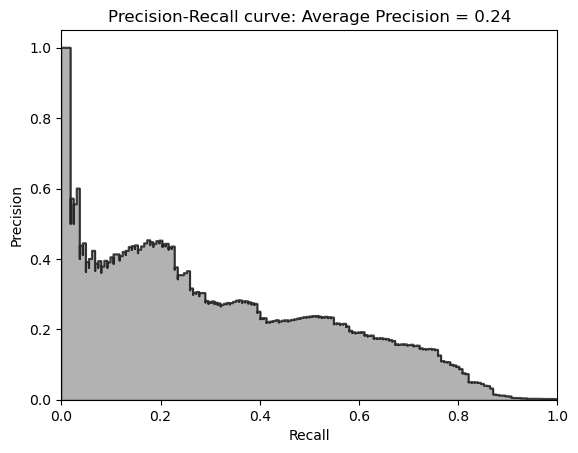

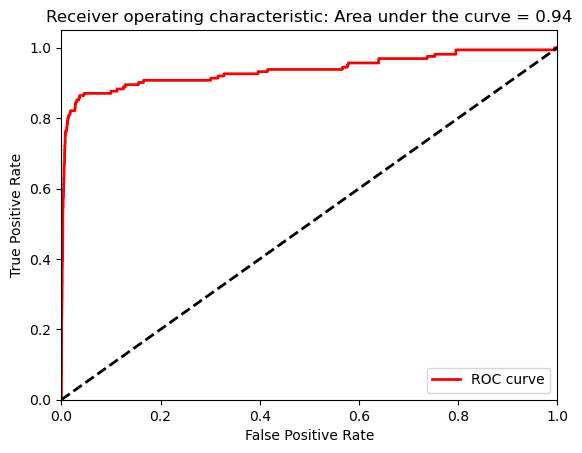

In [27]:
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Epoch 1/10
5964/5964 [==============================] - 30s 5ms/step - loss: 0.0781 - accuracy: 0.8987 - val_loss: 0.0014 - val_accuracy: 0.9888
Epoch 2/10
5964/5964 [==============================] - 30s 5ms/step - loss: 0.0017 - accuracy: 0.9881 - val_loss: 2.6846e-06 - val_accuracy: 0.9994
Epoch 3/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0017 - accuracy: 0.9934 - val_loss: 2.6631e-08 - val_accuracy: 0.9999
Epoch 4/10
5964/5964 [==============================] - 28s 5ms/step - loss: 4.9233e-04 - accuracy: 0.9944 - val_loss: 7.3808e-04 - val_accuracy: 0.9888
Epoch 5/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.4960e-04 - accuracy: 0.9936 - val_loss: 1.2727e-05 - val_accuracy: 0.9978
Epoch 6/10
5964/5964 [==============================] - 29s 5ms/step - loss: 6.8296e-04 - accuracy: 0.9930 - val_loss: 0.0010 - val_accuracy: 0.9911
Epoch 7/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.2275e-04 - accuracy: 0.

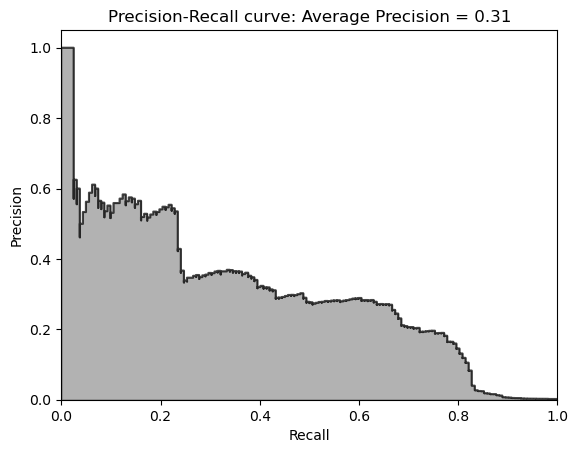

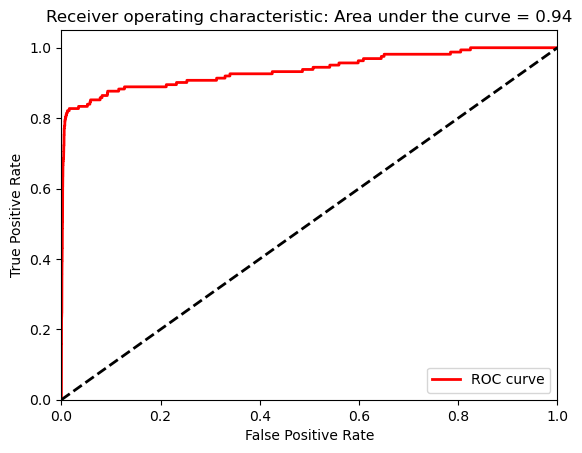

Epoch 1/10
5964/5964 [==============================] - 31s 5ms/step - loss: 0.0859 - accuracy: 0.8821 - val_loss: 9.8535e-04 - val_accuracy: 0.9904
Epoch 2/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.0011 - accuracy: 0.9918 - val_loss: 1.6061e-07 - val_accuracy: 0.9999
Epoch 3/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0021 - accuracy: 0.9938 - val_loss: 7.7715e-07 - val_accuracy: 0.9997
Epoch 4/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.1894e-04 - accuracy: 0.9939 - val_loss: 0.0024 - val_accuracy: 0.9751
Epoch 5/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.3322e-04 - accuracy: 0.9944 - val_loss: 2.1116e-07 - val_accuracy: 0.9998
Epoch 6/10
5964/5964 [==============================] - 29s 5ms/step - loss: 7.2438e-04 - accuracy: 0.9925 - val_loss: 6.9842e-04 - val_accuracy: 0.9935
Epoch 7/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.2272e-04 - accuracy

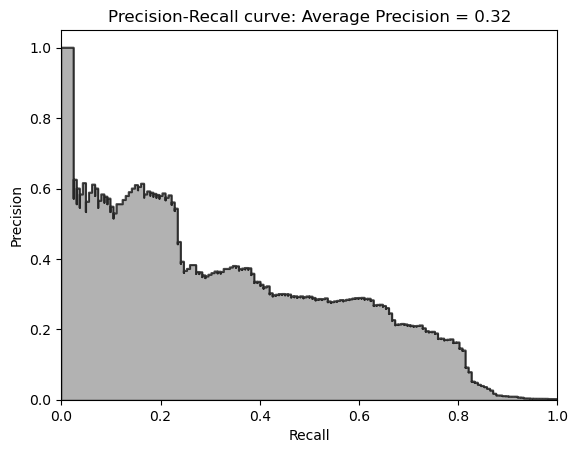

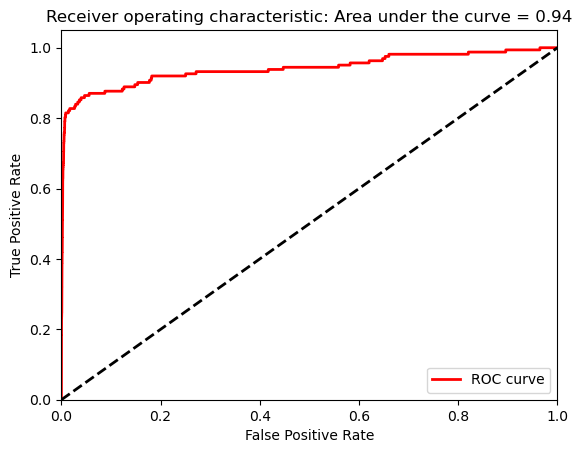

Epoch 1/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0928 - accuracy: 0.8776 - val_loss: 0.0017 - val_accuracy: 0.9878
Epoch 2/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0028 - accuracy: 0.9835 - val_loss: 0.0011 - val_accuracy: 0.9910
Epoch 3/10
5964/5964 [==============================] - 31s 5ms/step - loss: 0.0016 - accuracy: 0.9909 - val_loss: 1.4079e-06 - val_accuracy: 0.9996
Epoch 4/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.0954e-04 - accuracy: 0.9940 - val_loss: 0.0011 - val_accuracy: 0.9854
Epoch 5/10
5964/5964 [==============================] - 28s 5ms/step - loss: 5.7040e-04 - accuracy: 0.9935 - val_loss: 1.8511e-05 - val_accuracy: 0.9972
Epoch 6/10
5964/5964 [==============================] - 29s 5ms/step - loss: 6.7939e-04 - accuracy: 0.9932 - val_loss: 0.0011 - val_accuracy: 0.9926
Epoch 7/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.4521e-04 - accuracy: 0.9936 - v

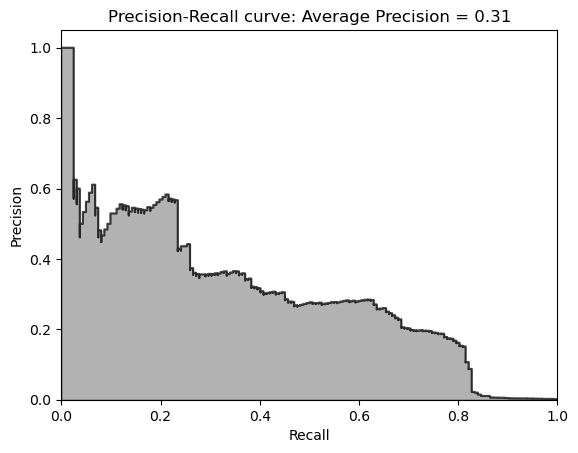

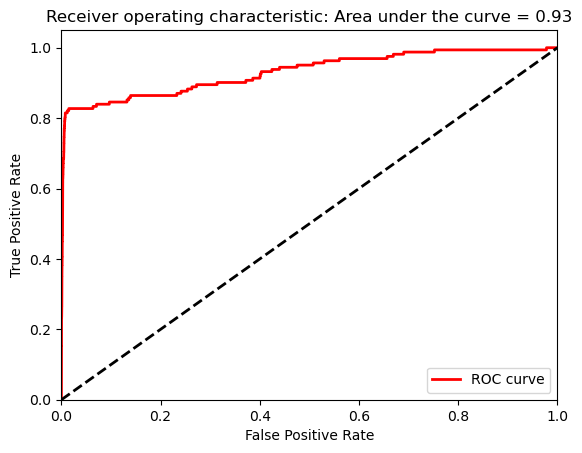

Epoch 1/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0891 - accuracy: 0.8989 - val_loss: 0.0014 - val_accuracy: 0.9881
Epoch 2/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.0020 - accuracy: 0.9867 - val_loss: 2.9126e-05 - val_accuracy: 0.9982
Epoch 3/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0017 - accuracy: 0.9930 - val_loss: 6.0631e-07 - val_accuracy: 0.9998
Epoch 4/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.1026e-04 - accuracy: 0.9935 - val_loss: 0.0011 - val_accuracy: 0.9870
Epoch 5/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.5943e-04 - accuracy: 0.9938 - val_loss: 2.8326e-05 - val_accuracy: 0.9967
Epoch 6/10
5964/5964 [==============================] - 29s 5ms/step - loss: 7.2412e-04 - accuracy: 0.9927 - val_loss: 0.0010 - val_accuracy: 0.9918
Epoch 7/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.5239e-04 - accuracy: 0.9936

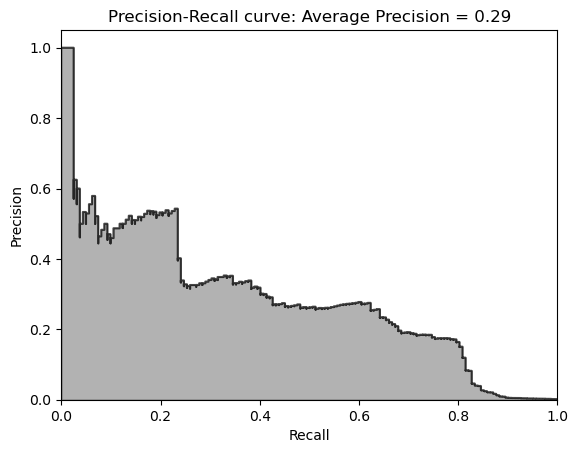

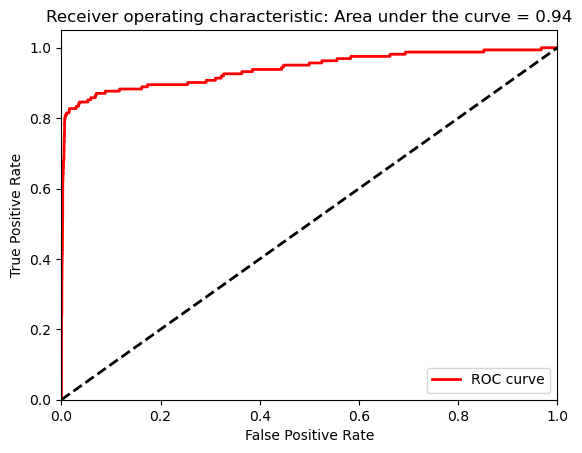

Epoch 1/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0979 - accuracy: 0.8916 - val_loss: 4.9769e-04 - val_accuracy: 0.9937
Epoch 2/10
5964/5964 [==============================] - 29s 5ms/step - loss: 9.9375e-04 - accuracy: 0.9918 - val_loss: 1.1342e-05 - val_accuracy: 0.9981
Epoch 3/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0011 - accuracy: 0.9945 - val_loss: 3.5395e-05 - val_accuracy: 0.9976
Epoch 4/10
5964/5964 [==============================] - 31s 5ms/step - loss: 5.3494e-04 - accuracy: 0.9939 - val_loss: 0.0060 - val_accuracy: 0.9632
Epoch 5/10
5964/5964 [==============================] - 32s 5ms/step - loss: 5.7016e-04 - accuracy: 0.9938 - val_loss: 2.9510e-05 - val_accuracy: 0.9965
Epoch 6/10
5964/5964 [==============================] - 30s 5ms/step - loss: 6.6319e-04 - accuracy: 0.9930 - val_loss: 8.2682e-04 - val_accuracy: 0.9933
Epoch 7/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.7001e-04 - accu

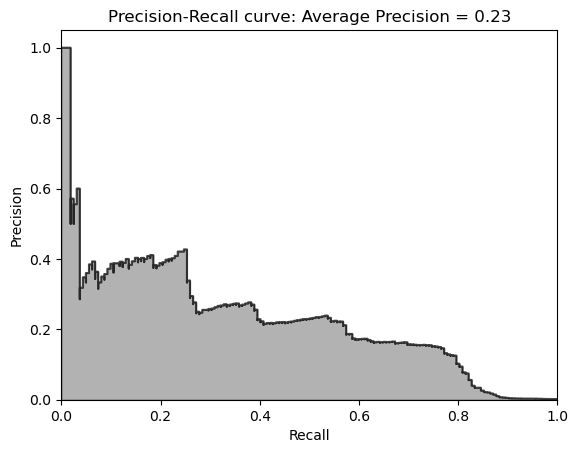

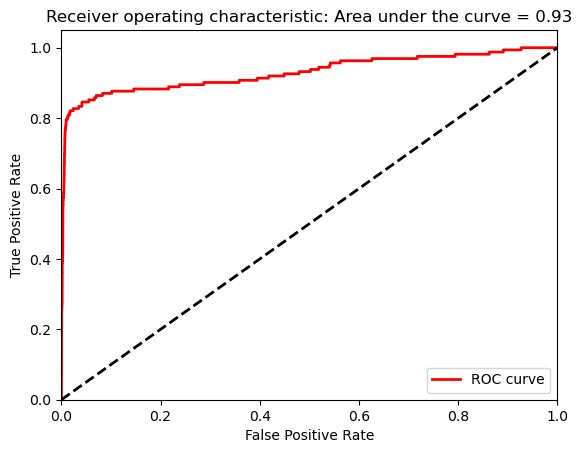

Epoch 1/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0908 - accuracy: 0.8849 - val_loss: 0.0010 - val_accuracy: 0.9903
Epoch 2/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0014 - accuracy: 0.9896 - val_loss: 4.0736e-07 - val_accuracy: 0.9997
Epoch 3/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0016 - accuracy: 0.9944 - val_loss: 2.0616e-06 - val_accuracy: 0.9994
Epoch 4/10
5964/5964 [==============================] - 31s 5ms/step - loss: 5.6906e-04 - accuracy: 0.9934 - val_loss: 0.0021 - val_accuracy: 0.9792
Epoch 5/10
5964/5964 [==============================] - 32s 5ms/step - loss: 5.7637e-04 - accuracy: 0.9932 - val_loss: 3.4837e-05 - val_accuracy: 0.9954
Epoch 6/10
5964/5964 [==============================] - 33s 5ms/step - loss: 6.4384e-04 - accuracy: 0.9931 - val_loss: 8.2189e-04 - val_accuracy: 0.9933
Epoch 7/10
5964/5964 [==============================] - 32s 5ms/step - loss: 5.5103e-04 - accuracy: 0.

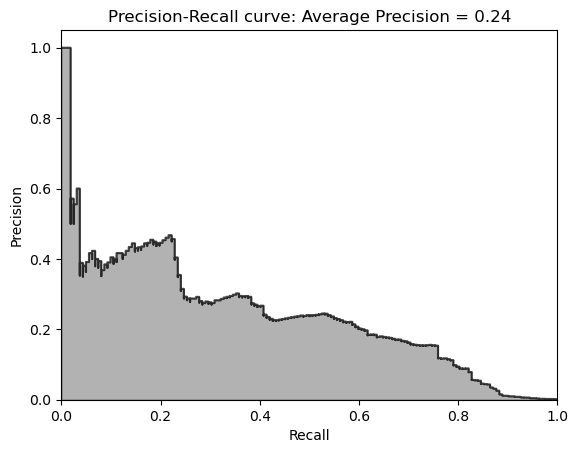

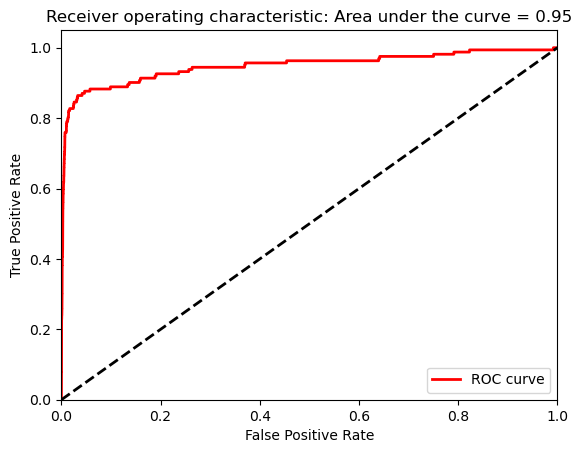

Epoch 1/10
5964/5964 [==============================] - 34s 5ms/step - loss: 0.0804 - accuracy: 0.8959 - val_loss: 3.5592e-04 - val_accuracy: 0.9942
Epoch 2/10
5964/5964 [==============================] - 38s 6ms/step - loss: 9.7857e-04 - accuracy: 0.9927 - val_loss: 1.5752e-06 - val_accuracy: 0.9995
Epoch 3/10
5964/5964 [==============================] - 33s 6ms/step - loss: 0.0023 - accuracy: 0.9935 - val_loss: 4.2162e-06 - val_accuracy: 0.9991
Epoch 4/10
5964/5964 [==============================] - 31s 5ms/step - loss: 4.5522e-04 - accuracy: 0.9938 - val_loss: 0.0018 - val_accuracy: 0.9821
Epoch 5/10
5964/5964 [==============================] - 31s 5ms/step - loss: 6.5900e-04 - accuracy: 0.9938 - val_loss: 1.7438e-05 - val_accuracy: 0.9971
Epoch 6/10
5964/5964 [==============================] - 30s 5ms/step - loss: 6.7869e-04 - accuracy: 0.9931 - val_loss: 6.4285e-04 - val_accuracy: 0.9932
Epoch 7/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.1266e-04 - accu

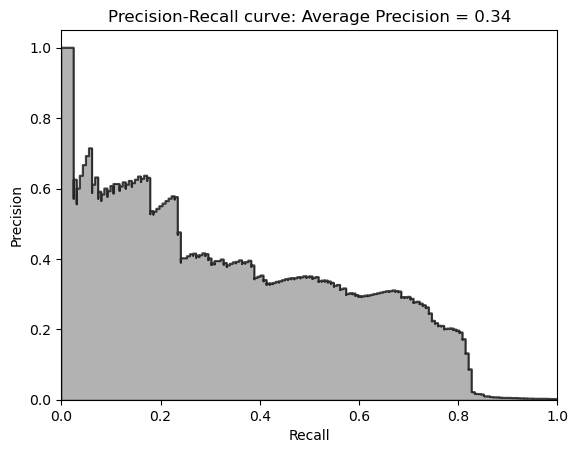

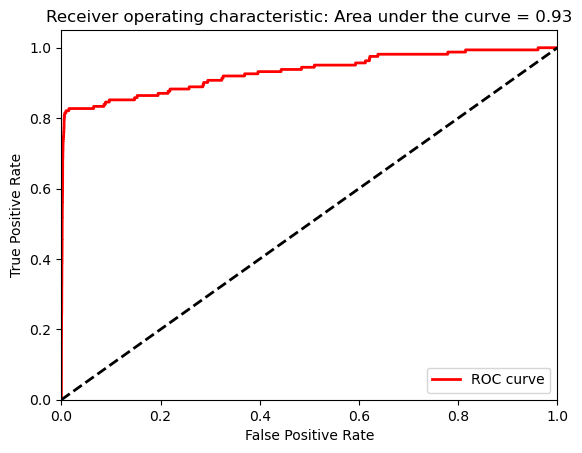

Epoch 1/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0895 - accuracy: 0.8932 - val_loss: 0.0012 - val_accuracy: 0.9896
Epoch 2/10
5964/5964 [==============================] - 40s 7ms/step - loss: 5.4509e-04 - accuracy: 0.9939 - val_loss: 2.8404e-05 - val_accuracy: 0.9969
Epoch 6/10
5964/5964 [==============================] - 33s 6ms/step - loss: 7.4091e-04 - accuracy: 0.9930 - val_loss: 0.0011 - val_accuracy: 0.9894
Epoch 7/10
5964/5964 [==============================] - 29s 5ms/step - loss: 6.4675e-04 - accuracy: 0.9931 - val_loss: 3.1003e-06 - val_accuracy: 0.9994
Epoch 8/10
5964/5964 [==============================] - 30s 5ms/step - loss: 4.4650e-04 - accuracy: 0.9955 - val_loss: 0.0020 - val_accuracy: 0.9757
Epoch 9/10
5964/5964 [==============================] - 31s 5ms/step - loss: 5.4986e-04 - accuracy: 0.9949 - val_loss: 3.8338e-06 - val_accuracy: 0.9996
Epoch 10/10
2938/2938 [==============================] - 7s 2ms/step


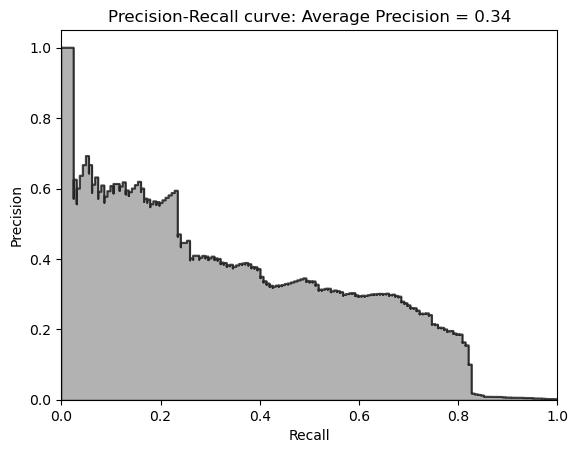

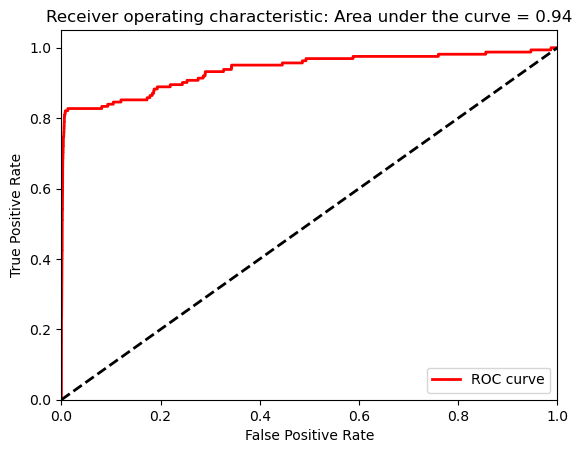

Epoch 1/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0903 - accuracy: 0.8892 - val_loss: 0.0015 - val_accuracy: 0.9887
Epoch 2/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0018 - accuracy: 0.9885 - val_loss: 5.0846e-06 - val_accuracy: 0.9994
Epoch 3/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0019 - accuracy: 0.9930 - val_loss: 6.9262e-07 - val_accuracy: 0.9996
Epoch 4/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.5038e-04 - accuracy: 0.9944 - val_loss: 0.0013 - val_accuracy: 0.9862
Epoch 5/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.7450e-04 - accuracy: 0.9938 - val_loss: 8.8290e-06 - val_accuracy: 0.9976
Epoch 6/10
5964/5964 [==============================] - 31s 5ms/step - loss: 7.2228e-04 - accuracy: 0.9930 - val_loss: 5.6814e-04 - val_accuracy: 0.9929
Epoch 7/10
5964/5964 [==============================] - 30s 5ms/step - loss: 5.3171e-04 - accuracy: 0.

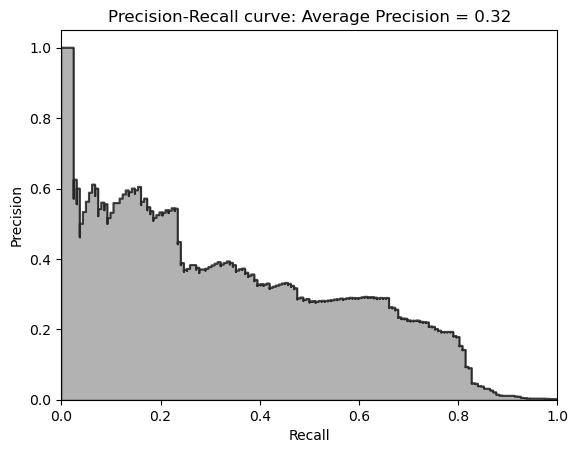

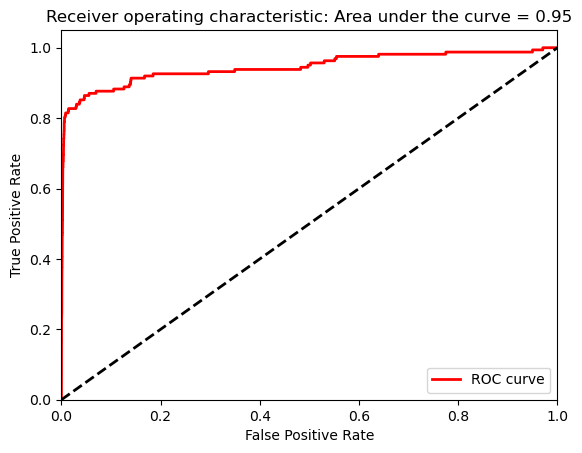

Epoch 1/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0946 - accuracy: 0.8866 - val_loss: 7.3052e-04 - val_accuracy: 0.9917
Epoch 2/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0011 - accuracy: 0.9914 - val_loss: 1.9006e-06 - val_accuracy: 0.9991
Epoch 3/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0014 - accuracy: 0.9928 - val_loss: 1.5329e-05 - val_accuracy: 0.9987
Epoch 4/10
5964/5964 [==============================] - 28s 5ms/step - loss: 4.8306e-04 - accuracy: 0.9941 - val_loss: 7.8933e-04 - val_accuracy: 0.9915
Epoch 5/10
5964/5964 [==============================] - 30s 5ms/step - loss: 6.0799e-04 - accuracy: 0.9939 - val_loss: 1.1201e-05 - val_accuracy: 0.9977
Epoch 6/10
5964/5964 [==============================] - 29s 5ms/step - loss: 7.0724e-04 - accuracy: 0.9931 - val_loss: 9.7903e-04 - val_accuracy: 0.9933
Epoch 7/10
5964/5964 [==============================] - 29s 5ms/step - loss: 5.8912e-04 - accu

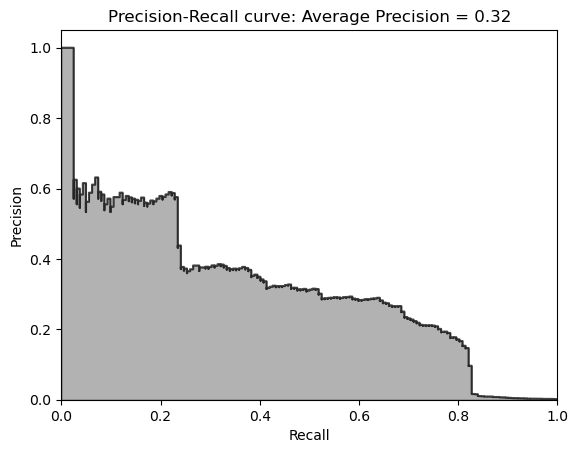

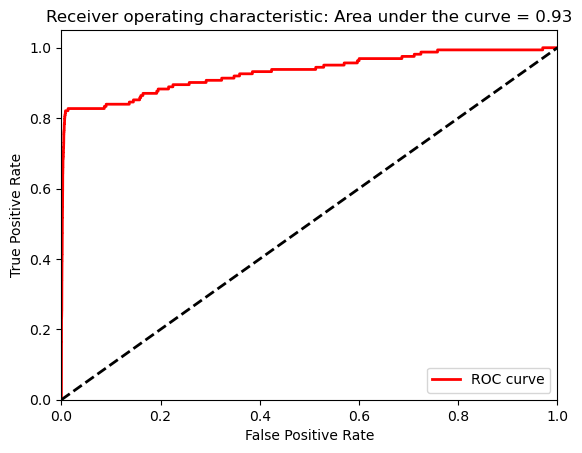

Mean average precision over 10 runs: 0.3021571379945958


[0.3086, 0.3167, 0.3057, 0.2909, 0.231, 0.2446, 0.3435, 0.3391, 0.3184, 0.323]

In [29]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [30]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

Mean average precision over 10 runs:   0.3022
Coefficient of variation over 10 runs: 0.1172


[0.3086, 0.3167, 0.3057, 0.2909, 0.231, 0.2446, 0.3435, 0.3391, 0.3184, 0.323]

**MODEL TWO**

**Two layer undercomplete autoencoder with linear activation 20 nodes in hidden layer**

Epoch 1/10
5964/5964 [==============================] - 31s 5ms/step - loss: 0.3516 - accuracy: 0.5698 - val_loss: 0.2774 - val_accuracy: 0.6287
Epoch 2/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.2806 - accuracy: 0.6351 - val_loss: 0.2764 - val_accuracy: 0.6608
Epoch 3/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.2799 - accuracy: 0.6678 - val_loss: 0.2755 - val_accuracy: 0.6704
Epoch 4/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.2796 - accuracy: 0.6670 - val_loss: 0.2755 - val_accuracy: 0.6832
Epoch 5/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.2788 - accuracy: 0.6748 - val_loss: 0.2745 - val_accuracy: 0.6852
Epoch 6/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.2780 - accuracy: 0.6816 - val_loss: 0.2753 - val_accuracy: 0.6768
Epoch 7/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.2779 - accuracy: 0.6793 - val_loss: 0.2739 - val_ac

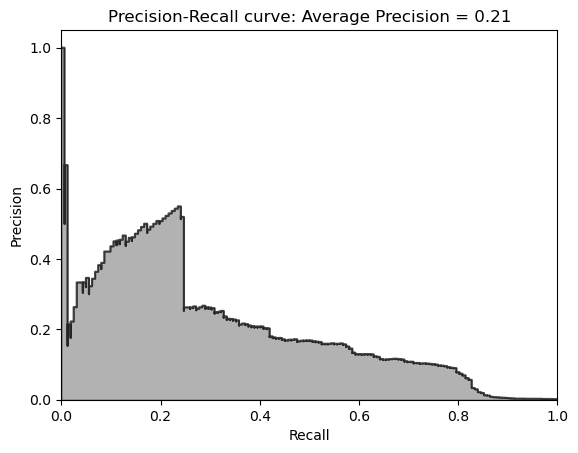

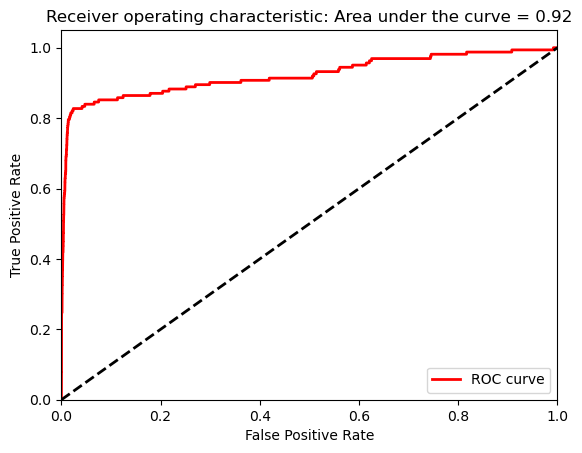

Epoch 1/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.3481 - accuracy: 0.5747 - val_loss: 0.2771 - val_accuracy: 0.6299
Epoch 2/10
4907/5964 [=======================>......] - ETA: 2s - loss: 0.2830 - accuracy: 0.6338

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**MODEL TWO V2**

**Two layer undercomplete autoencoder with linear activation
With 27 nodes this time**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**MODEL 3**
  
**Three layer undercomplete autoencoder with linear activation.**

    
**With 28 and 27 nodes in the two hidden layers, respectively**

In [ ]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

     # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f'Mean average precision over 10 runs: {np.mean(test_scores)}')
[round(x,4) for x in test_scores]

**Model 4**
  
**Four layer undercomplete autoencoder with ReLu activation**

    
**29 -> 27 -> 22 -> 27 -> 29**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**Model 5**

  
**Two layer overcomplete autoencoder with linear activation and dropout**
    
**29 -> 40 -> 29**
    
**Dropout percentage: 10%**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**Model 6**

**Two layer sparse overcomplete autoencoder with linear activation**
    
**29 -> 40 -> 29**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**Model 7**

**Two layer sparse overcomplete autoencoder with linear activation and dropout**

**29 -> 40 -> 29**
    
**Dropout percentage: 5%**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train, y=scaled_X_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_test, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()
    
print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**Model 8**
  
**Two layer denoising undercomplete autoencoder with linear activation**
    
**29 -> 27 -> 29**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
scaled_X_train_noisy = scaled_X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=scaled_X_train.shape)
scaled_X_train_noisy = scaled_X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=scaled_X_train.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train_noisy, y=scaled_X_train_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_train_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**Model 9**
  
**Two layer denoising overcomplete autoencoder with linear activation**
    
**And sparsity regularizer and dropout**

**29 -> 40 -> 29**

**Dropout percentage: 5%**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
scaled_X_train_noisy = scaled_X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=scaled_X_train.shape)
scaled_X_train_noisy = scaled_X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=scaled_X_train.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train_noisy, y=scaled_X_train_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_train_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**Model 10**

**Two layer denoising overcomplete autoencoder with ReLU activation**

**And sparsity regularizer and dropout**

**29 -> 40 -> 29**

**Dropout percentage: 5%**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
scaled_X_train_noisy = scaled_X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=scaled_X_train.shape)
scaled_X_train_noisy = scaled_X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=scaled_X_train.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu', activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=scaled_X_train_noisy, y=scaled_X_train_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(scaled_X_train, scaled_X_train),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(scaled_X_train_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(scaled_X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]

In [ ]:
print(f'Mean average precision over 10 runs:   {round(np.mean(test_scores),4)}')
print(f'Coefficient of variation over 10 runs: {round(np.std(test_scores)/np.mean(test_scores),4)}')
[round(x,4) for x in test_scores]

**CONCLUSION**

In [ ]:
import datetime as dt
print("Completed: ", dt.datetime.now())